# Script 03: Label Transfer (scANVI)

NB: this notebook showcases the workflow by integrating & labeling the two knockout (ko) samples with the controls. For doing the same with ko_bmt and ei conditions, the query data can be altered under section II. ii.

## Steps involved:

### i. pre-processing & HVG selection
### ii. scVI integration -> joint latent space
### iii. scANVI cell type prediction (labelTransfer)

In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad

In [2]:
import scvi
import torch
import seaborn as sns
import tempfile

# scvi seed (torch and numpy) and version print
scvi.settings.seed = 0
torch.set_float32_matmul_precision("high")
print("Last run with scvi-tools version:", scvi.__version__)

# plotting parameters
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()

save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

/home/koellere/miniconda3/envs/scvi-tools/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 0


Last run with scvi-tools version: 1.2.2.post2


I. functions

In [3]:
# HELPER FUNCTION: build adata from basic blocks
def build_sample_adata(
    sample_dir,
    sample_id,
    matrix_name="matrix.mtx",
    barcodes_name="barcodes.tsv",
    features_name="features.tsv",
    cell_metadata_name="metadata.csv",
    obs_label_for_sample="mouse_id"
):

    # build file paths
    matrix_path = os.path.join(sample_dir, matrix_name)
    barcodes_path = os.path.join(sample_dir, barcodes_name)
    features_path = os.path.join(sample_dir, features_name)
    cell_metadata_path = os.path.join(sample_dir, cell_metadata_name)

    # read cts matrix and transpose
    adata = sc.read_mtx(matrix_path).T

    # barcodes & features
    barcodes = pd.read_csv(barcodes_path, header=None, sep="\t")[0]
    features = pd.read_csv(features_path, header=None, sep="\t")[0]

    # assign to the adata object
    adata.obs_names = barcodes
    adata.var_names = features

    # store sampleID as a column
    adata.obs[obs_label_for_sample] = sample_id

    # check for cell metadata
    if not os.path.exists(cell_metadata_path):
        raise FileNotFoundError(f"No cell metadata: {cell_metadata_path}")

    # read in cell meta
    cell_meta = pd.read_csv(cell_metadata_path,
                            index_col=0,
                            )

    # test indices overlap
    assert all(idx in adata.obs.index for idx in cell_meta.index)

    # merge cell meta based on indices
    adata.obs = adata.obs.join(cell_meta, how='left')

    return adata

II. read in data

In [4]:
# cellranger counts
data_dir = os.path.join("data", "cellranger")

In [5]:
# sample-level metadata
sample_meta = pd.read_csv("data/mice_and_batches.csv")

i. reference

In [6]:
# only ctrls here
ctrl_samples = sample_meta[sample_meta["genotype"] == "ctrl"]

In [7]:
# loop over all the samples
adatas = []
for idx, row in ctrl_samples.iterrows():
    sample_id = str(row["mouse_id"])
    sample_dir = os.path.join(data_dir, sample_id, "outs", "soupx")

    adata = build_sample_adata(
        sample_dir=sample_dir,
        sample_id=sample_id,
        matrix_name="matrix.mtx",
        barcodes_name="barcodes.tsv",
        features_name="features.tsv",
        cell_metadata_name="metadata.csv",
        obs_label_for_sample="mouse_id"
    )
    adatas.append(adata)

In [8]:
# merge with anndata.concat()
adata_ref = ad.concat(adatas, axis=0)

adata_ref

AnnData object with n_obs × n_vars = 11107 × 33696
    obs: 'mouse_id', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'old_label', 'percent.mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'counts_outlier', 'features_outlier', 'mito_outlier', 'RNA_snn_res.0.8', 'seurat_clusters', 'scDblFinder.class', 'scDblFinder.score', 'S.Score', 'G2M.Score', 'Phase'

In [9]:
# make sampleIDs catcategorical
adata_ref.obs["mouse_id"] = adata_ref.obs["mouse_id"].astype("category")

In [10]:
# add batch info
sample_meta["mouse_id"] = sample_meta["mouse_id"].astype(str).astype("category")
sample_to_batch = sample_meta.set_index("mouse_id")["batch"]
adata_ref.obs["batch"] = adata_ref.obs["mouse_id"].map(sample_to_batch)

In [11]:
del(adatas)

ii. query

In [12]:
# ko samples
current_samples = sample_meta[sample_meta["genotype"] == "ko"]

In [13]:
# loop over all the samples
adatas = []
for idx, row in current_samples.iterrows():
    sample_id = str(row["mouse_id"])
    sample_dir = os.path.join(data_dir, sample_id, "outs", "soupx")

    adata = build_sample_adata(
        sample_dir=sample_dir,
        sample_id=sample_id,
        matrix_name="matrix.mtx",
        barcodes_name="barcodes.tsv",
        features_name="features.tsv",
        cell_metadata_name="metadata.csv",
        obs_label_for_sample="mouse_id"
    )
    adatas.append(adata)

In [14]:
# merge with anndata.concat()
adata_query = ad.concat(adatas, axis=0)

adata_query

AnnData object with n_obs × n_vars = 6689 × 33696
    obs: 'mouse_id', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'old_label', 'percent.mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'counts_outlier', 'features_outlier', 'mito_outlier', 'RNA_snn_res.0.8', 'seurat_clusters', 'scDblFinder.class', 'scDblFinder.score', 'S.Score', 'G2M.Score', 'Phase'

In [15]:
# make sampleIDs catcategorical
adata_query.obs["mouse_id"] = adata_query.obs["mouse_id"].astype("category")

In [17]:
# add batch info
adata_query.obs["batch"] = adata_query.obs["mouse_id"].map(sample_to_batch)

In [18]:
del(adatas)

iii. add reference cell labels

Cell labels were generated by iterating through clusters at different resolutions and inspecting marker genes using the Seurat FindMarkers() function. The results of this tedious process have been made available in Suppl. Figs 5 and 6 as well as Supplemental Table 1, which contains all marker genes.

In [19]:
# load cell labels
ref_meta = pd.read_csv("renv/results/21_FINAL_reference_labels/metadata.csv",
                       index_col=0)

In [20]:
# merge into adata.obs
adata_ref.obs = adata_ref.obs.join(ref_meta["cell_type"], how='left')

In [21]:
# add label for ko cells to predict
adata_query.obs["cell_type"] = "unknown"

iv. merge

In [22]:
adata = ad.concat([adata_ref, adata_query], axis=0)

In [23]:
adata.shape

(17796, 33696)

III. pre-process & inspect

i. pre-process

In [24]:
# save raw counts for scVI
adata.layers["raw_counts"] = adata.X.copy()

In [25]:
# normalize counts
sc.pp.normalize_total(adata, 
                      target_sum=1e4, 
                      inplace=True)

In [26]:
# log+1 transform
sc.pp.log1p(adata)

In [27]:
# block HVGs by batch and by mouse_id
sc.pp.highly_variable_genes(adata, 
                            batch_key="batch", 
                            n_top_genes=3000, 
                            inplace=True)

In [28]:
# load cell cycle genes
s_genes = pd.read_csv("metadata/cell_cycle/mart_export_s.txt", header=None)[2].tolist()
g2m_genes = pd.read_csv("metadata/cell_cycle/mart_export_g2m.txt", header=None)[2].tolist()
cell_cycle_genes = set(s_genes + g2m_genes)

In [29]:
hvgs = adata.var_names[adata.var['highly_variable']]
len(hvgs)

3000

In [30]:
# remove them from HVG selection
hvgs_filtered = set(hvgs) - cell_cycle_genes
len(hvgs_filtered)

2999

In [31]:
# save those HVGs
pd.DataFrame({'highly_variable_genes': list(hvgs_filtered)}).to_csv(
    "n3000_blocked_by_batch_CCFiltered.csv", index=False
)

In [32]:
# and set these HVGs
adata.var['highly_variable'] = adata.var.index.isin(hvgs_filtered)

ii. Rough unintegrated inspection

In [33]:
import igraph

In [34]:
sc.pp.pca(adata,
          n_comps=30,
          use_highly_variable=True)

/home/koellere/miniconda3/envs/scvi-tools/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [35]:
sc.pp.neighbors(adata)

In [36]:
sc.tl.leiden(adata,
             key_added = "leiden_unintegrated")

/tmp/ipykernel_39783/3087533994.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata,


In [37]:
sc.tl.umap(adata)

In [38]:
adata.obsm['X_umap_unintegrated'] = adata.obsm['X_umap'] 

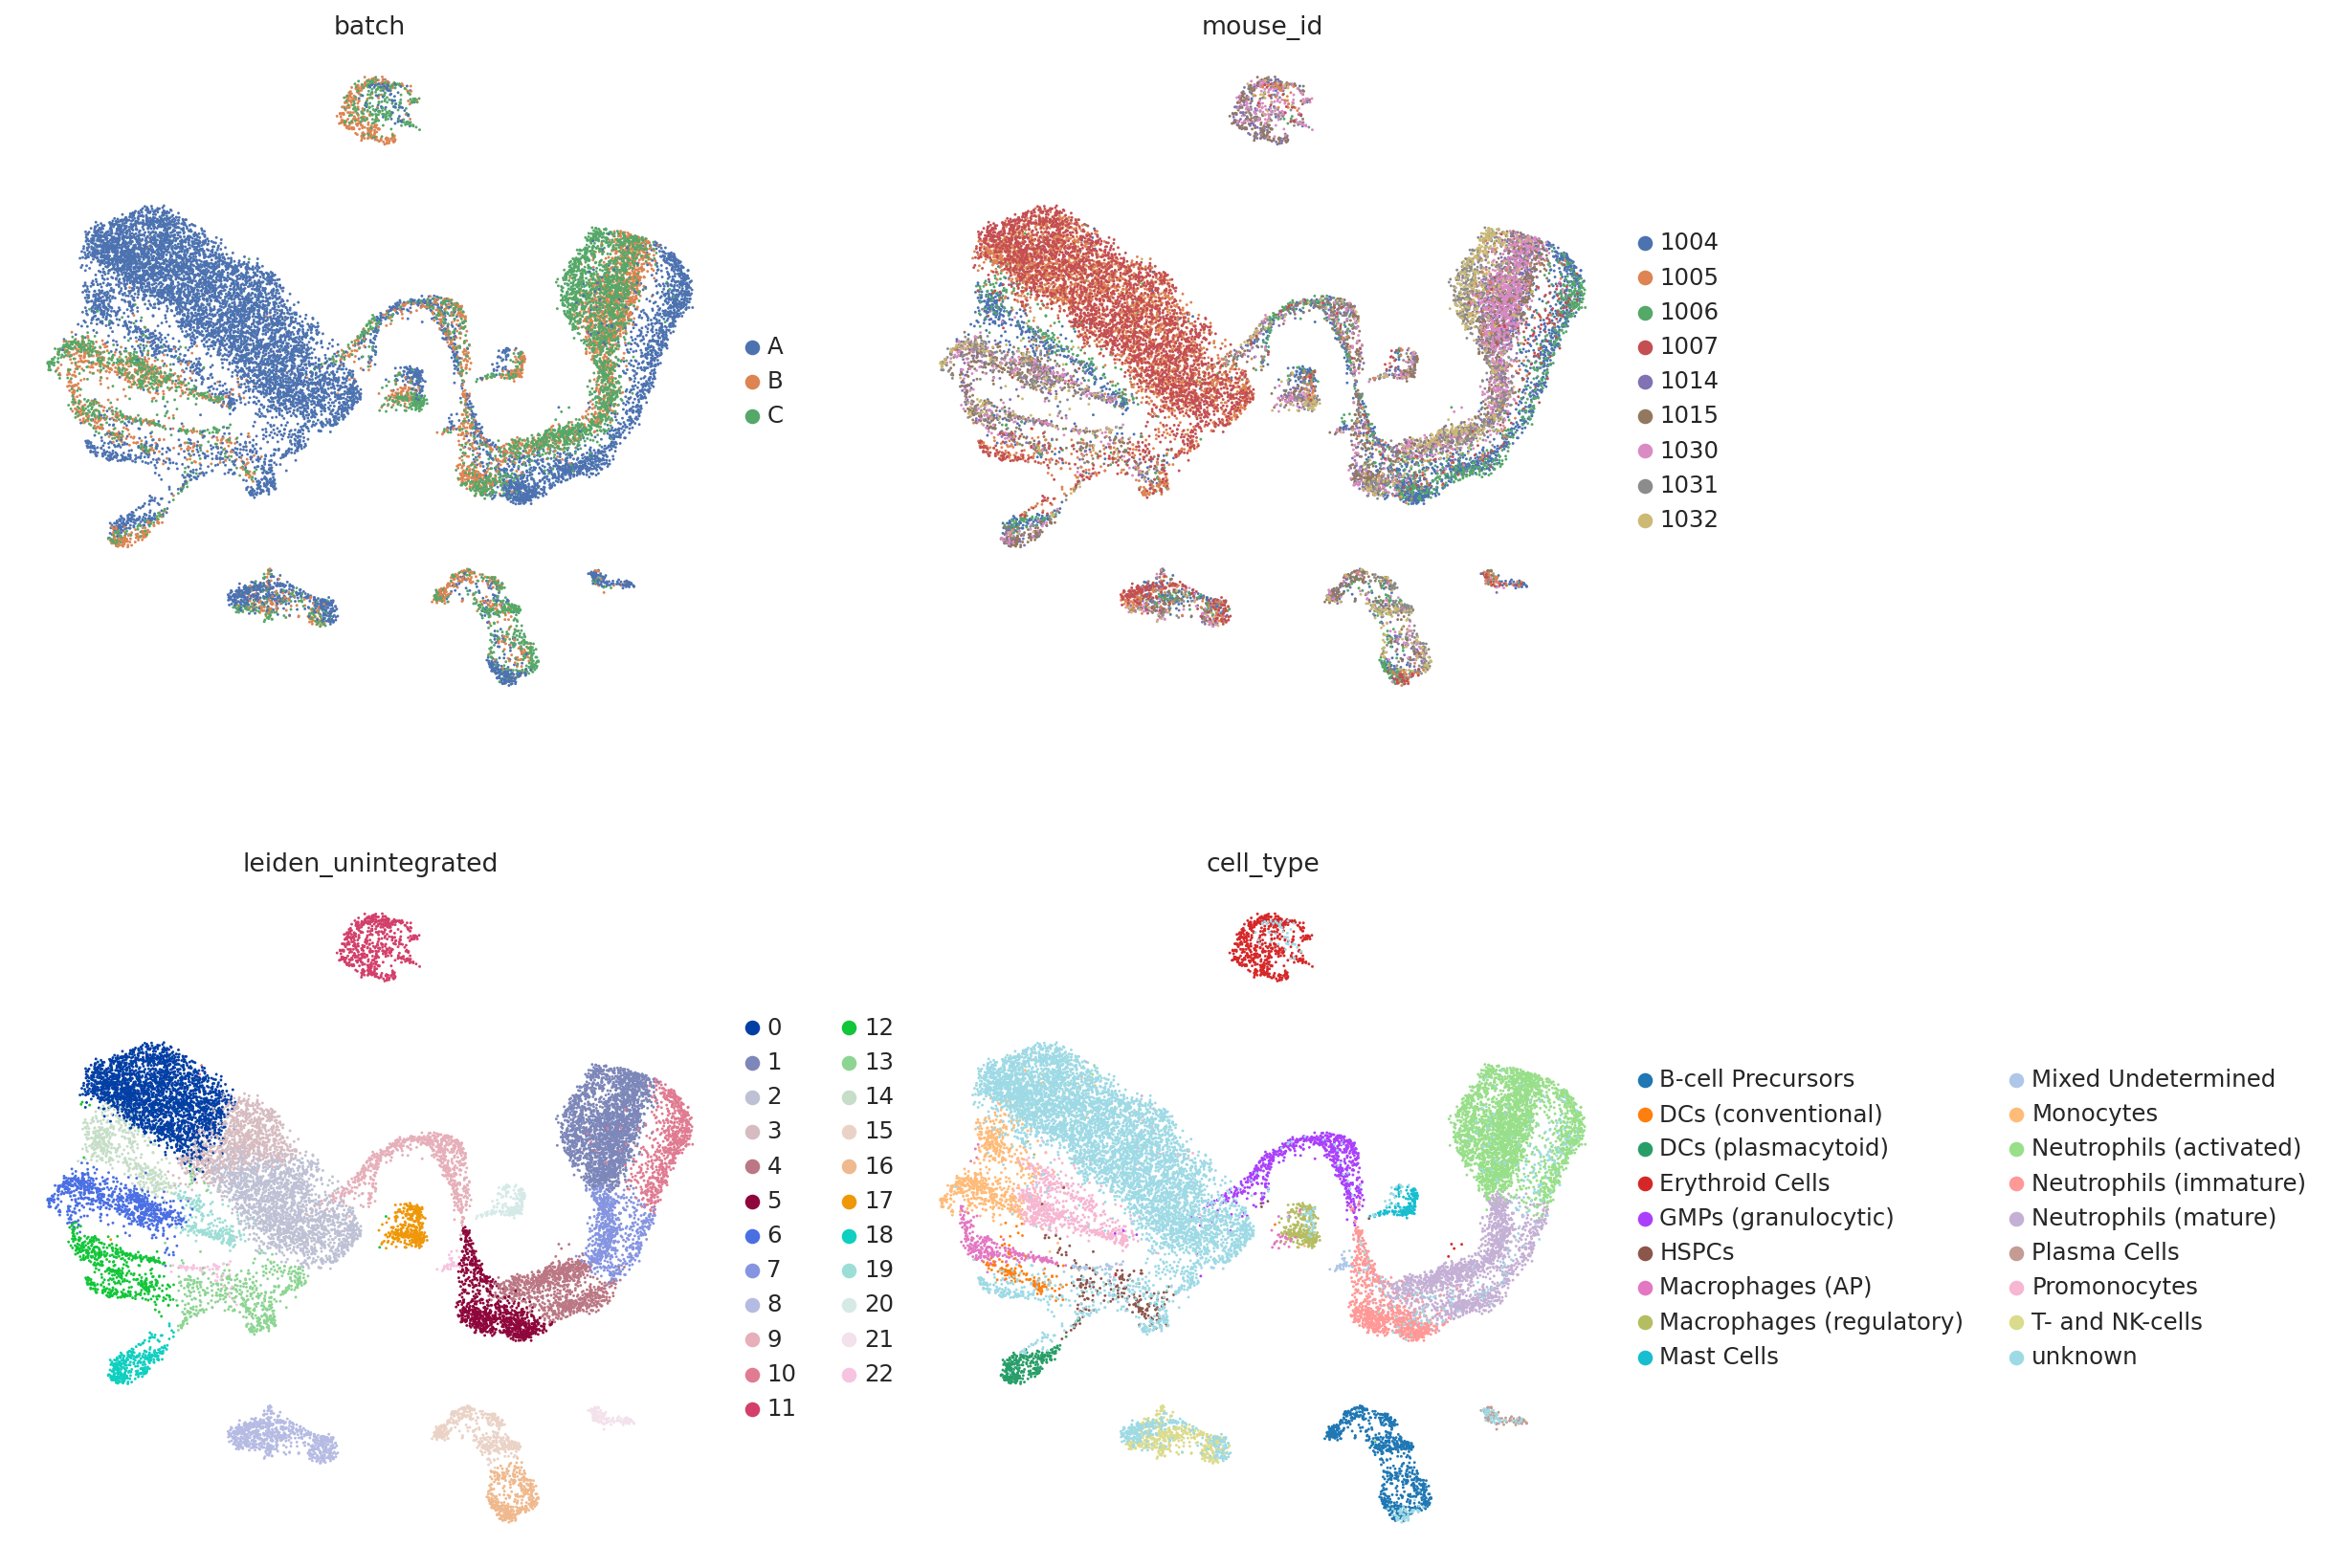

In [39]:
sc.pl.embedding(adata,
                basis = "X_umap_unintegrated",
                color = ["batch", "mouse_id", "leiden_unintegrated", "cell_type"],
                ncols=2,
                save="_overview.png")

iii. Extract hvg subset for scVI

In [40]:
adata_vae = adata[:, adata.var["highly_variable"]].copy()
adata_vae

AnnData object with n_obs × n_vars = 17796 × 2999
    obs: 'mouse_id', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'old_label', 'percent.mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'counts_outlier', 'features_outlier', 'mito_outlier', 'RNA_snn_res.0.8', 'seurat_clusters', 'scDblFinder.class', 'scDblFinder.score', 'S.Score', 'G2M.Score', 'Phase', 'batch', 'cell_type', 'leiden_unintegrated'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden_unintegrated', 'umap', 'batch_colors', 'mouse_id_colors', 'leiden_unintegrated_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_unintegrated'
    varm: 'PCs'
    layers: 'raw_counts'
    obsp: 'distances', 'connectivities'

In [41]:
# make sure raw counts are still present
adata_vae.layers

Layers with keys: raw_counts

In [42]:
from scipy.sparse import csr_matrix

In [43]:
# make sparse (speeds up scVI afair)
if 'raw_counts' in adata_vae.layers:
    if not isinstance(adata_vae.layers["raw_counts"], csr_matrix):
        adata_vae.layers["raw_counts"] = csr_matrix(adata_vae.layers["raw_counts"])
        print("Converted adata_vae.layers['raw_counts'] to CSR format.")
    else:
        print("adata_vae.layers['raw_counts'] is already in CSR format.")
else:
    print("No 'raw_counts' layer found in adata_vae.")

adata_vae.layers['raw_counts'] is already in CSR format.


IV. scVI integration

i. total epochs and stopping params

In [44]:
scvi_epochs = 500
early_stopping_kwargs_scvi = {
    "early_stopping": True, 
    "early_stopping_monitor": 'elbo_train',
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
}

plan_kwargs_scvi = {
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

ii. set up adata

In [45]:
# set up anndata for model training
scvi.model.SCVI.setup_anndata(adata_vae, 
                              batch_key="batch",
                              layer="raw_counts",
                              #size_factor_key="sizeFactor"
                              labels_key="cell_type"
                              )

iii. model params

In [46]:
# model paramters
scvi_model = scvi.model.SCVI(adata_vae, 
                        n_layers=2, 
                        n_latent=25, 
                        #n_hidden=128 # 128 default
                        gene_likelihood="zinb" # zero inflated negative binomial - should be on point for scRNA-seq
                        )

In [47]:
scvi_model.train(
    max_epochs=scvi_epochs,
    plan_kwargs=plan_kwargs_scvi,
    check_val_every_n_epoch=1,
    **early_stopping_kwargs_scvi
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/koellere/miniconda3/envs/scvi-tools/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/koellere/miniconda3/envs/scvi-tools/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/koellere/miniconda3/envs/scvi-tools/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19

Epoch 299/500:  60%|█████▉    | 299/500 [09:10<06:10,  1.84s/it, v_num=1, train_loss_step=419, train_loss_epoch=474]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 479.652. Signaling Trainer to stop.


V. inspect integration

In [48]:
# get latent space
adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

In [49]:
# run basic analysis
sc.pp.neighbors(adata, 
                use_rep="X_scVI")
sc.tl.leiden(adata,
             key_added="leiden_scVI")

In [50]:
sc.tl.umap(adata)

In [51]:
adata.obsm['X_scVI_umap'] = adata.obsm['X_umap']

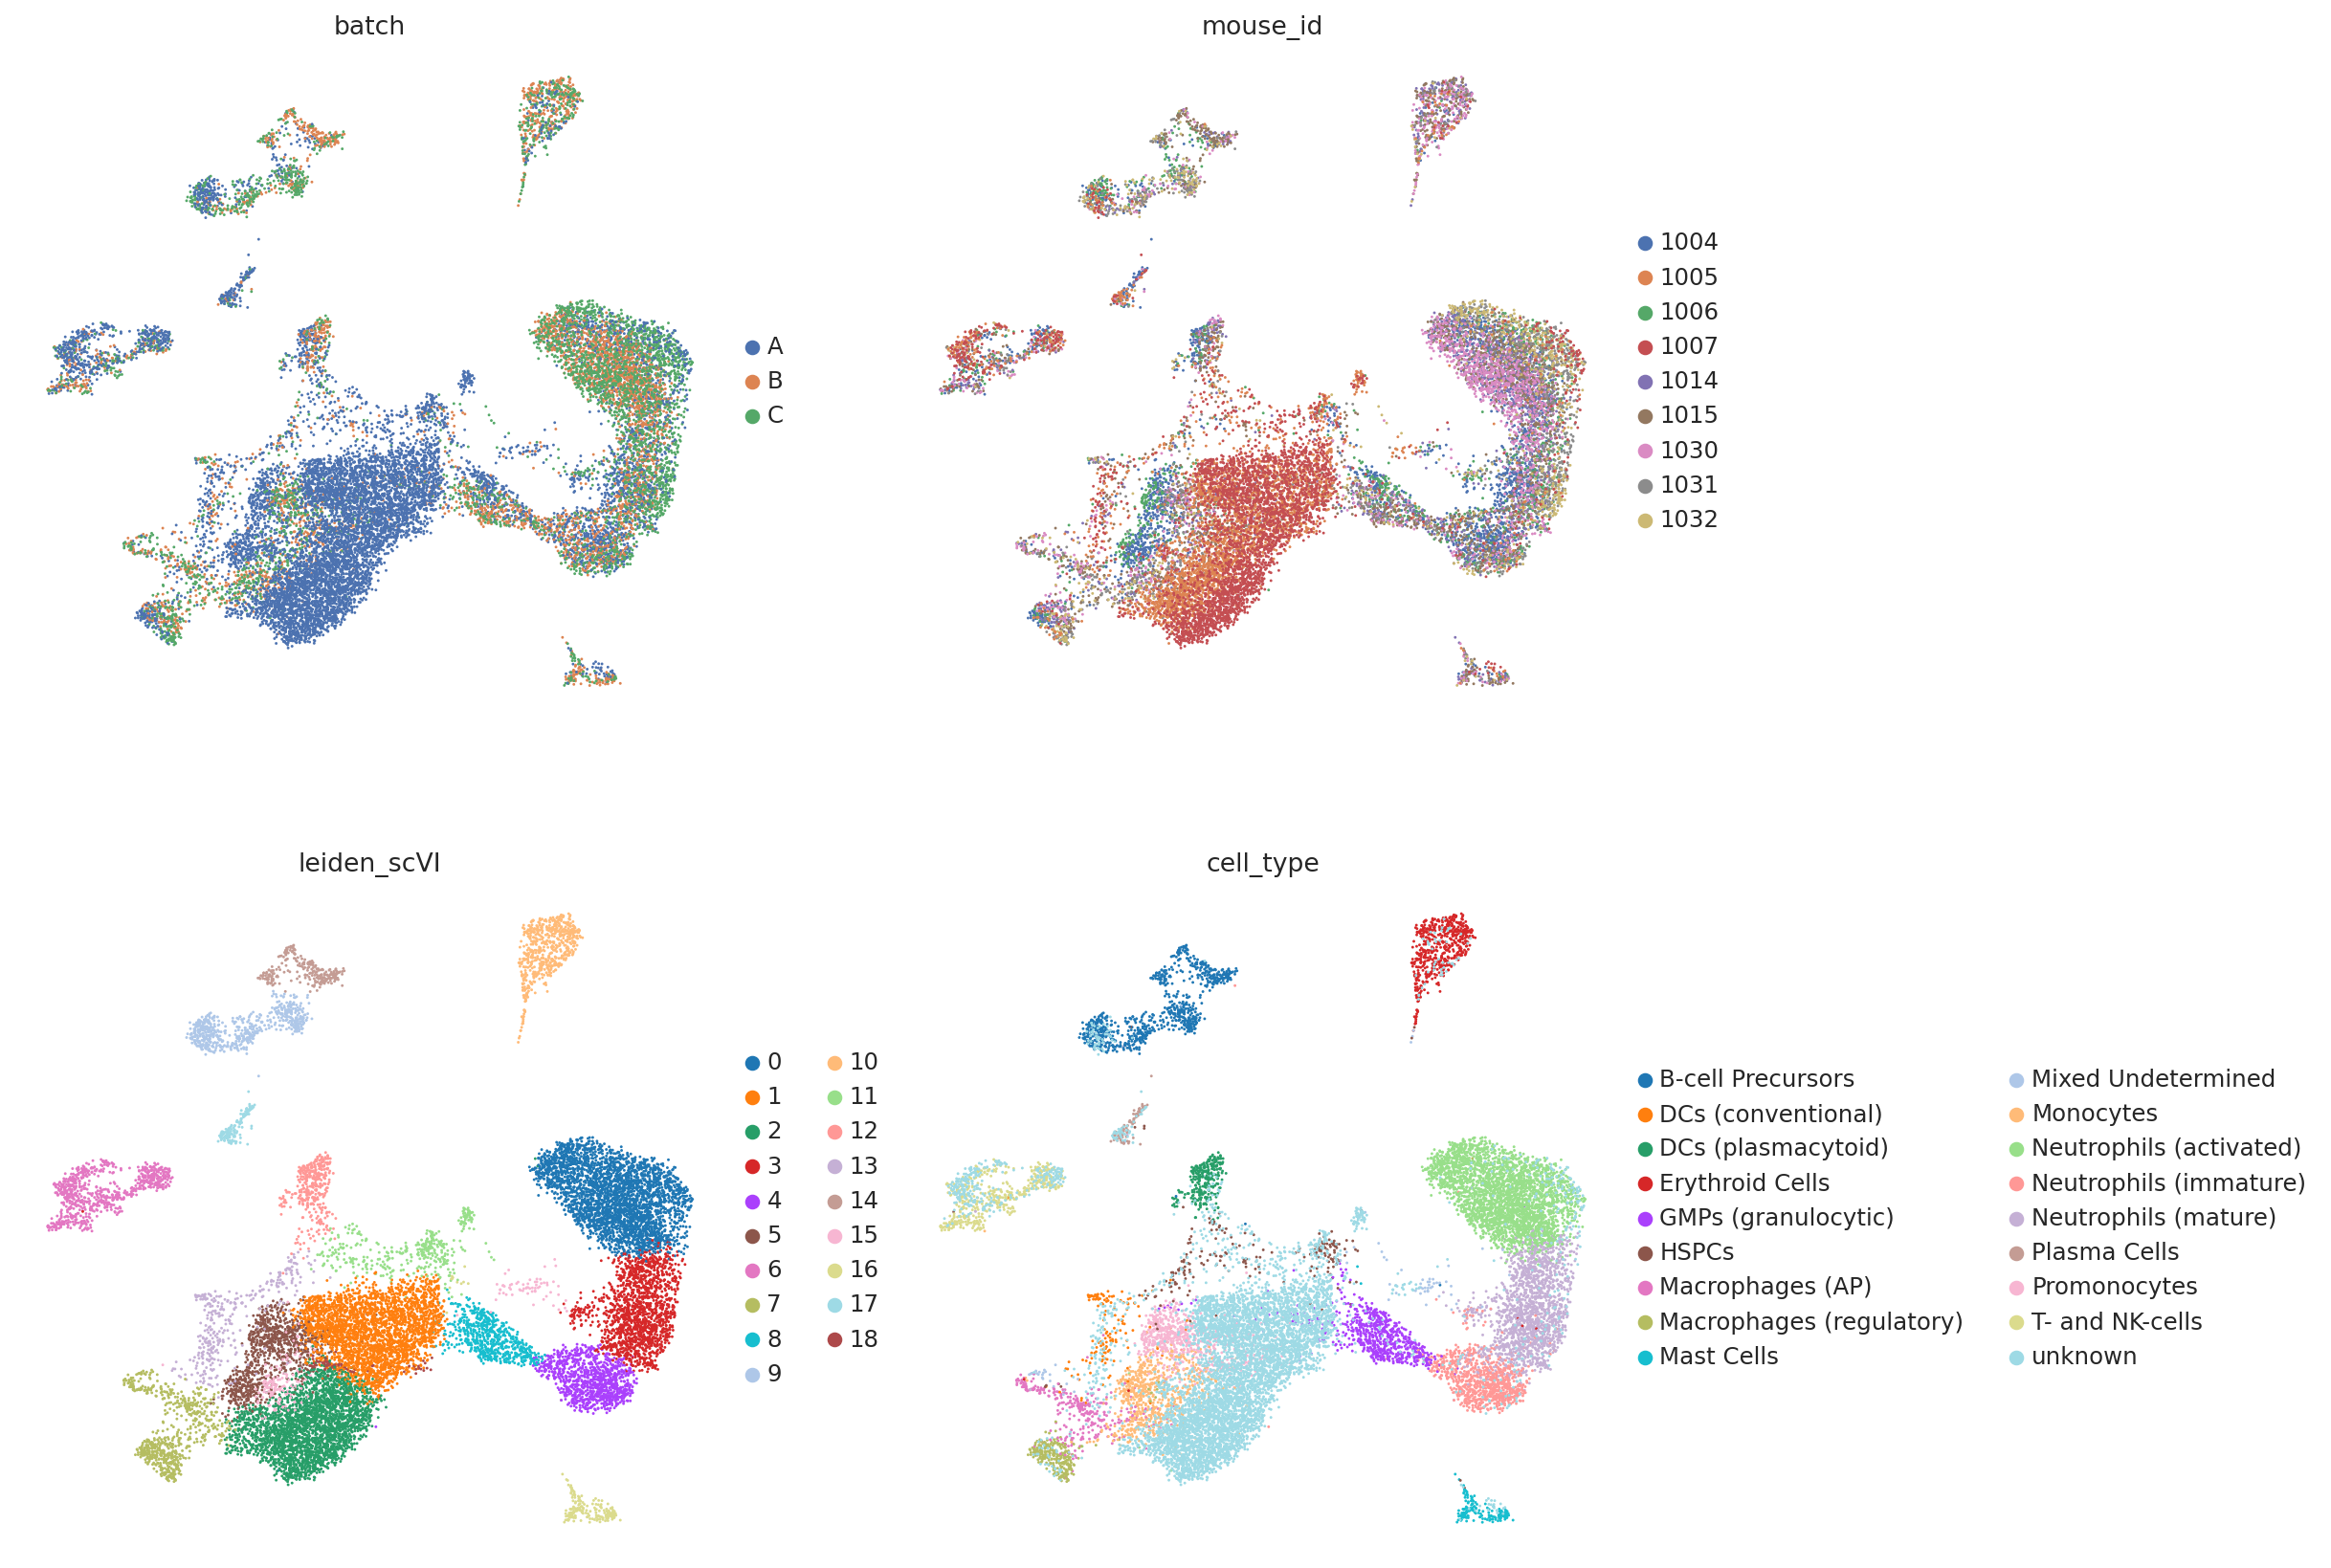

In [52]:
sc.pl.embedding(adata,
                basis = "X_scVI_umap",
                color = ["batch", "mouse_id", "leiden_scVI", "cell_type"],
                ncols=2,
                save="_overview.png")

VI. scANVI label transfer

i. early stopping params

In [53]:
scanvi_epochs = 200
early_stopping_kwargs_scanvi = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001
}
plan_kwargs_scanvi = {
    "weight_decay": 0.0
}

ii. model params

In [54]:
adata_vae.obs["cell_type"].values

['Neutrophils (mature)', 'Neutrophils (immature)', 'Neutrophils (immature)', 'Neutrophils (immature)', 'Monocytes', ..., 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
Length: 17796
Categories (18, object): ['B-cell Precursors', 'DCs (conventional)', 'DCs (plasmacytoid)', 'Erythroid Cells', ..., 'Plasma Cells', 'Promonocytes', 'T- and NK-cells', 'unknown']

In [55]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata_vae,
    labels_key="cell_type",
    unlabeled_category="unknown"
)

iii. train

In [56]:
scanvi_model.train(
    max_epochs=scanvi_epochs,
    check_val_every_n_epoch=1,
    plan_kwargs=plan_kwargs_scanvi,
    **early_stopping_kwargs_scanvi
)

INFO     Training for 200 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/koellere/miniconda3/envs/scvi-tools/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/koellere/miniconda3/envs/scvi-tools/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 11/200:   6%|▌         | 11/200 [00:47<13:38,  4.33s/it, v_num=1, train_loss_step=593, train_loss_epoch=460]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 504.195. Signaling Trainer to stop.


VII. inspect label transfer

In [57]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation()

In [58]:
# run basic analysis
sc.pp.neighbors(adata, 
                use_rep="X_scANVI")
sc.tl.leiden(adata,
             key_added="leiden_scANVI")

In [59]:
# compute umap embedding
sc.tl.umap(adata)

In [60]:
adata.obsm['X_scANVI_umap'] = adata.obsm['X_umap']

In [61]:
# extract predictions
adata.obs["scanvi_predictions"] = scanvi_model.predict()

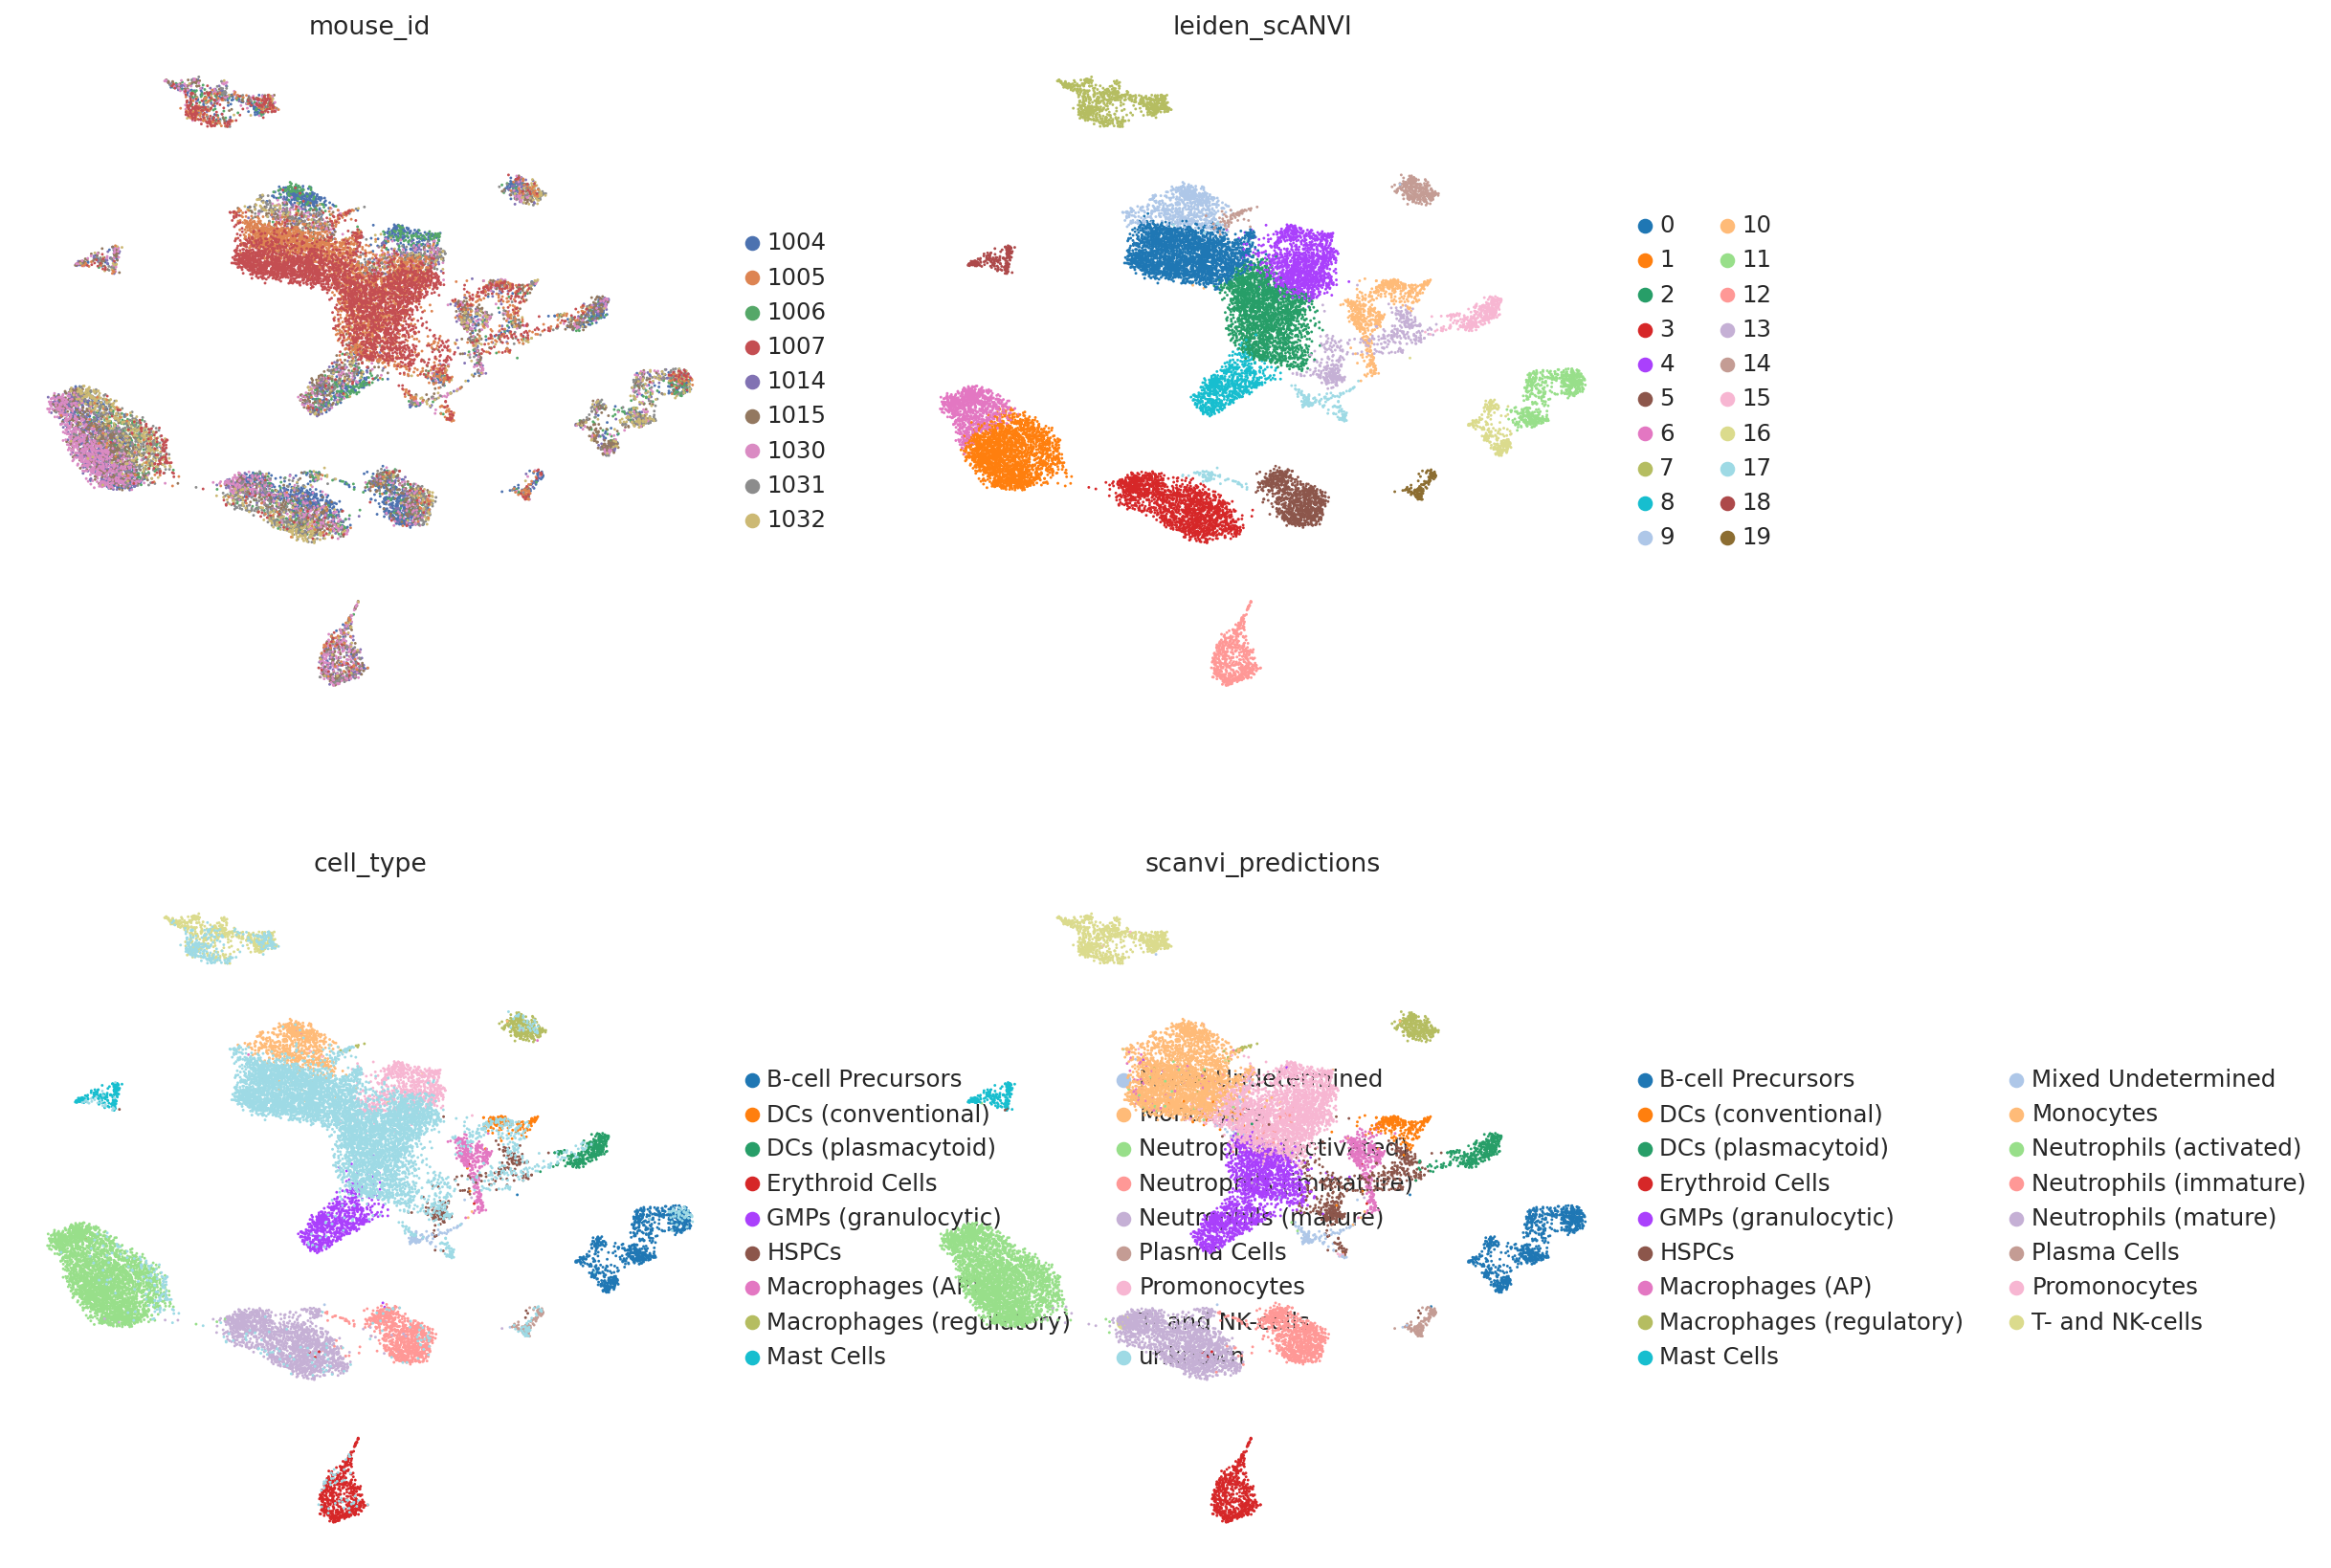

In [63]:
sc.pl.embedding(adata,
                basis = "X_scANVI_umap",
                color = ["mouse_id", "leiden_scANVI", "cell_type", "scanvi_predictions"],
                ncols=2,
                save="_overview.png")

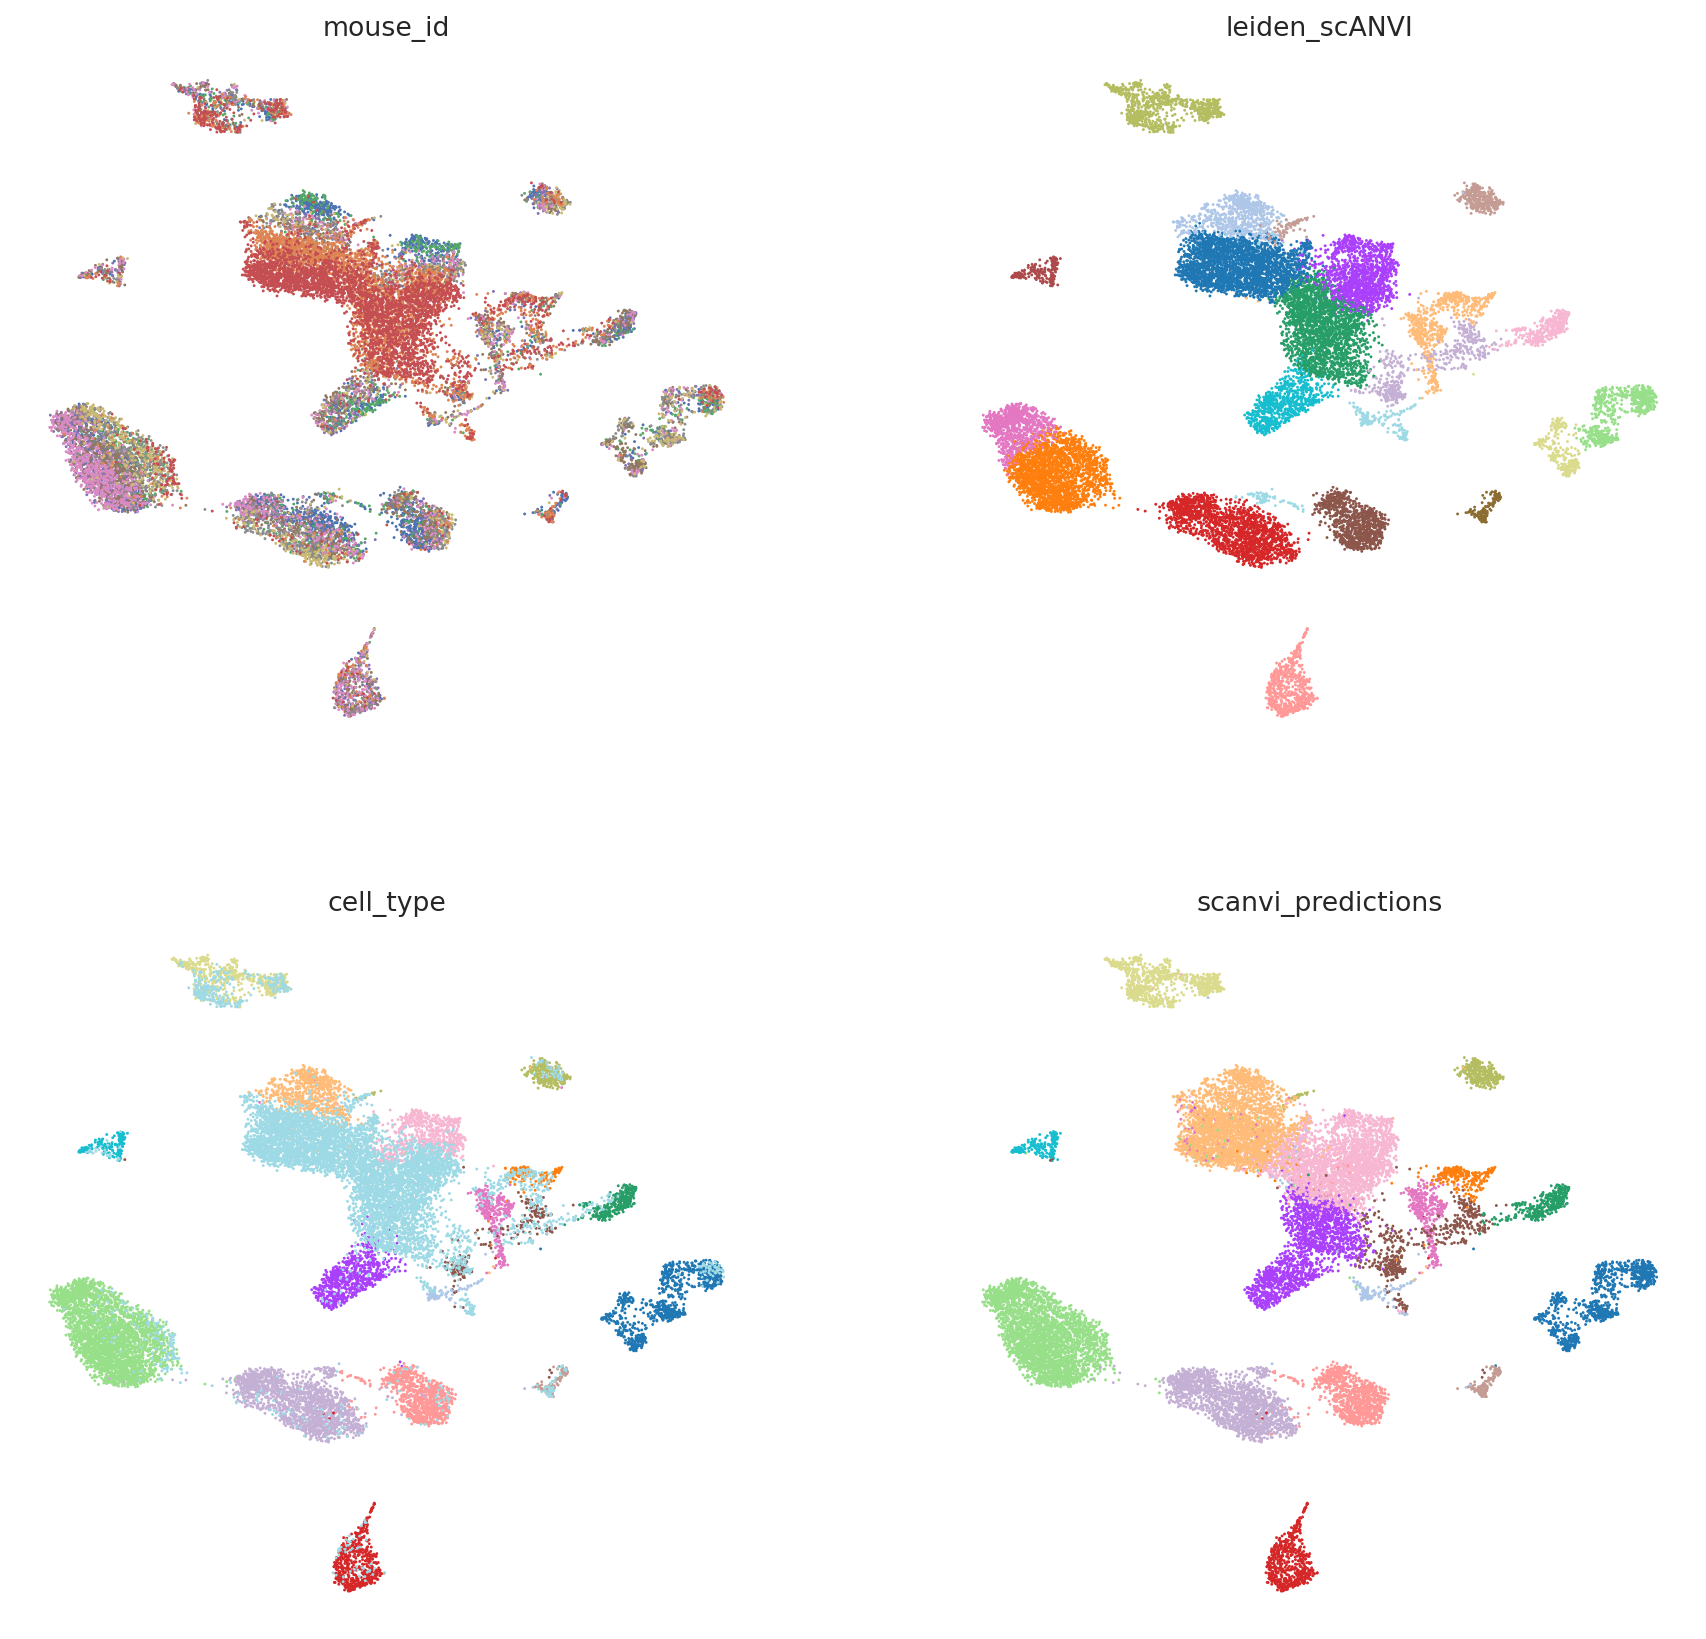

In [64]:
sc.pl.embedding(adata,
                basis = "X_scANVI_umap",
                color = ["mouse_id", "leiden_scANVI", "cell_type", "scanvi_predictions"],
                ncols=2,
                legend_loc = None,
                save="_overview_noLeg.png")

In [65]:
predicted_probs = scanvi_model.predict(adata_vae, soft=True)

In [66]:
# surrogate for some form of prediction score
adata.obs["scanvi_max_prob"] = np.max(predicted_probs.values, axis=1)

VIII. save data

In [70]:
scvi_df = pd.DataFrame(adata.obsm['X_scVI'], 
                       index=adata.obs.index)
scvi_df.to_csv('X_scVI.csv', 
               index=True)

In [71]:
scvi_umap_df = pd.DataFrame(adata.obsm['X_scVI_umap'], 
                               index=adata.obs.index)
scvi_umap_df.to_csv('X_scVI_umap.csv', 
                       index=True)

In [72]:
scanvi_df = pd.DataFrame(adata.obsm['X_scANVI'], 
                       index=adata.obs.index)
scanvi_df.to_csv('X_scANVI.csv', 
               index=True)

In [73]:
scanvi_umap_df = pd.DataFrame(adata.obsm['X_scANVI_umap'], 
                               index=adata.obs.index)
scanvi_umap_df.to_csv('X_scANVI_umap.csv', 
                       index=True)

In [74]:
unintegrated_umap_df = pd.DataFrame(adata.obsm['X_umap_unintegrated'], 
                                    index=adata.obs.index)
unintegrated_umap_df.to_csv('X_umap_unintegrated.csv', 
                            index=True)

In [69]:
prediction_df = adata.obs.loc[adata.obs["mouse_id"].isin(current_samples["mouse_id"])]
prediction_df.to_csv("scanvi_results.csv",
               index=True)